In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense,Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.utils import class_weight

import time


In [2]:
# Load the dataset
train_df = pd.read_csv(r"C:\Users\haris\drt\dataset\drugsComTrain_raw.csv", sep=',')
test_df = pd.read_csv(r"C:\Users\haris\drt\dataset\drugsComTest_raw.csv", sep=',')

In [3]:
train_df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
test_df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [5]:
# Drop rows with missing values in 'review' or 'rating'
train_test_df = pd.concat([train_df, test_df], ignore_index=True)
train_test_df.dropna(subset=['review', 'rating', 'usefulCount'], inplace=True)
train_test_df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [6]:
#remove special charecters from reviews
train_test_df['review'] = train_test_df['review'].str.replace(r'[^\w\s]', '', regex=True)

In [7]:
# Convert date to datetime for easier processing
train_test_df['date'] = pd.to_datetime(train_test_df['date'], format='%d-%b-%y')

# Extract year from date and group by year to count number of ratings
train_test_df['year'] = train_test_df['date'].dt.year
ratings_count_per_year = train_test_df.groupby('year').size().reset_index(name='number_of_ratings')

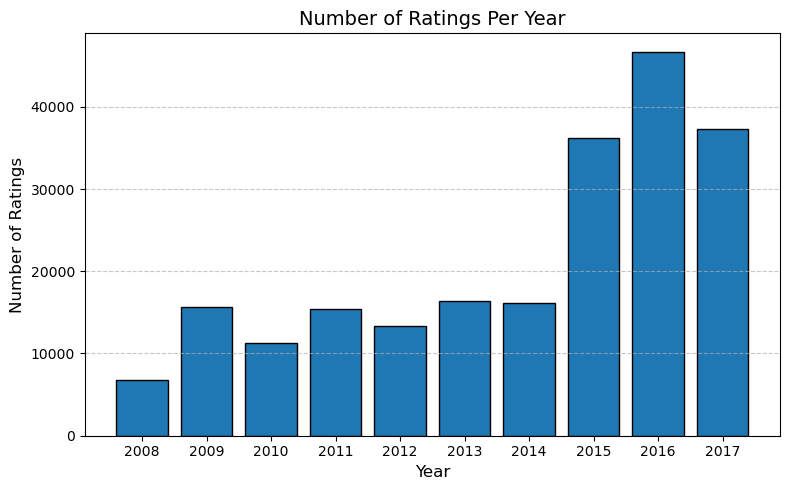

In [8]:
# Plot the number of ratings per year
plt.figure(figsize=(8, 5))
plt.bar(ratings_count_per_year['year'], ratings_count_per_year['number_of_ratings'], edgecolor='black')
plt.title('Number of Ratings Per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.xticks(ratings_count_per_year['year'], fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

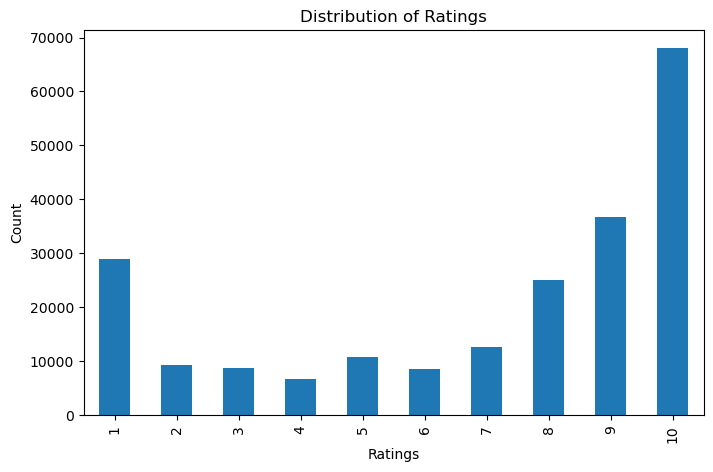

In [9]:
#plot bar graph for ratings 
plt.figure(figsize=(8, 5))
train_test_df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()


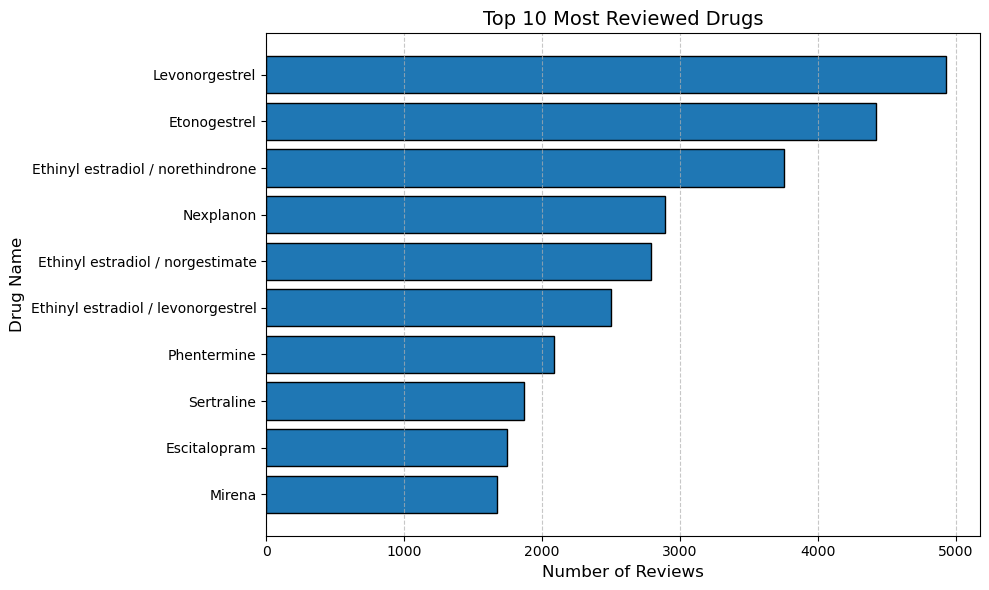

In [10]:
# Count the number of reviews for each drug
most_reviewed_drugs = train_test_df['drugName'].value_counts().reset_index()
most_reviewed_drugs.columns = ['drugName', 'review_count']

# Get the top 10 most reviewed drugs
top_10_most_reviewed_drugs = most_reviewed_drugs.head(10)

# Plot the top 10 most reviewed drugs in a bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_10_most_reviewed_drugs['drugName'], top_10_most_reviewed_drugs['review_count'], edgecolor='black')
plt.title('Top 10 Most Reviewed Drugs', fontsize=14)
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Drug Name', fontsize=12)
plt.gca().invert_yaxis()  # To display the highest value on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

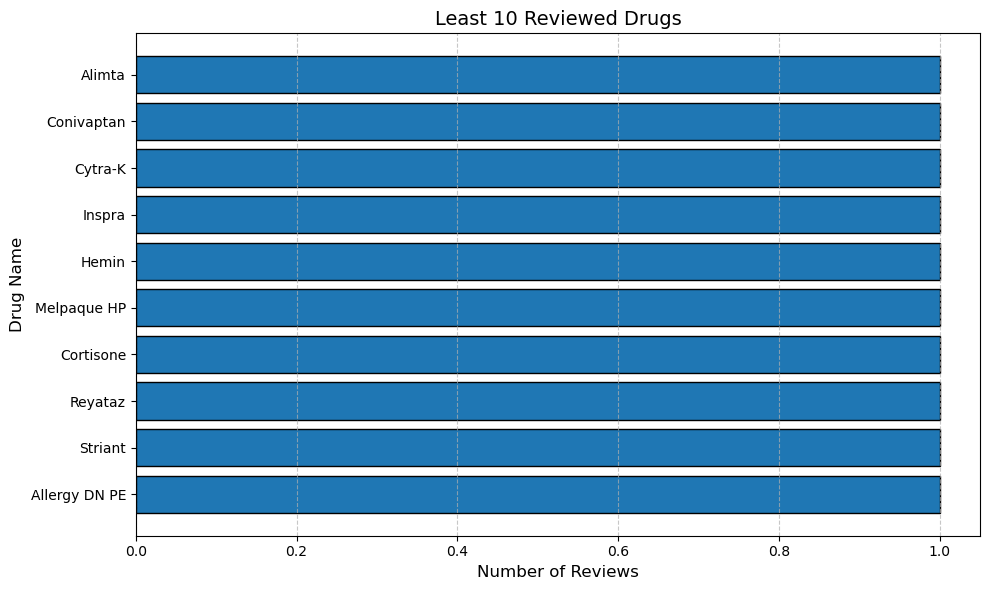

In [11]:
# Get the least 10 reviewed drugs
least_10_reviewed_drugs = most_reviewed_drugs.tail(10)

# Plot the least 10 reviewed drugs in a bar chart
plt.figure(figsize=(10, 6))
plt.barh(least_10_reviewed_drugs['drugName'], least_10_reviewed_drugs['review_count'], edgecolor='black')
plt.title('Least 10 Reviewed Drugs', fontsize=14)
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Drug Name', fontsize=12)
plt.gca().invert_yaxis()  # To display the lowest value on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:
train_test=train_test_df

In [13]:
# Convert reviews to lowercase
train_test['review'] = train_test['review'].astype(str).str.lower()

In [14]:
# Generate sentiment labels: 1 for positive, 0 for negative
train_test['sentiment'] = train_test['rating'].apply(lambda x: 1 if x >= 5 else 0)


In [15]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_test['review'], 
    train_test['sentiment'], 
    test_size=0.2, 
    random_state=42
)

In [16]:
# Initialize and fit the vectorizer (term frequency inverse document frequency) tfidf score
vectorizer = TfidfVectorizer(max_features=10000) 
X_train_tfidf = vectorizer.fit_transform(X_train) #sparse matrix with row training review and column with word and tfidf score
X_val_tfidf = vectorizer.transform(X_val)#transform validation data into same feature (if review in 2nd column in  matrix, tfidfscore of drug will also at same column

In [17]:
# Initialize and train the SVM model
svc = LinearSVC(dual=False)
svc.fit(X_train_tfidf, y_train)
# Measure training time
start_time_train_svc = time.time()
svc.fit(X_train_tfidf, y_train)  
end_time_train_svc = time.time()


In [18]:
# Validation predictions and metrics
# Measure testing time
start_time_test_svc = time.time()
val_pred = svc.predict(X_val_tfidf)
end_time_test_svc = time.time()
print(f"LinearSVC Training Time: {end_time_train_svc - start_time_train_svc:.2f} seconds")
print(f"LinearSVC Testing Time: {end_time_test_svc - start_time_test_svc:.2f} seconds")

print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("Classification Report:\n", classification_report(y_val, val_pred))

LinearSVC Training Time: 7.68 seconds
LinearSVC Testing Time: 0.01 seconds
Validation Accuracy: 0.8642038453490805
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.66      0.71     10722
           1       0.89      0.93      0.91     32291

    accuracy                           0.86     43013
   macro avg       0.83      0.80      0.81     43013
weighted avg       0.86      0.86      0.86     43013



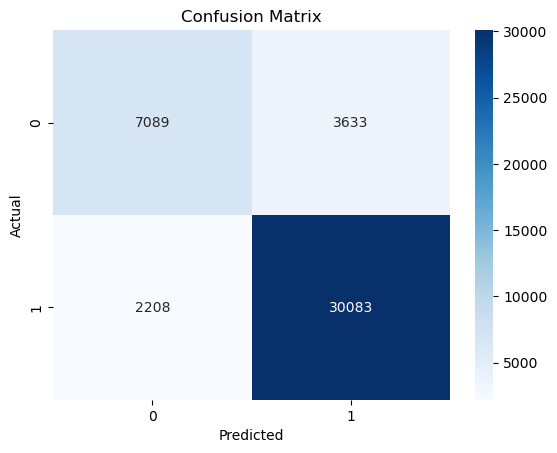

In [19]:
# Confusion matrix heatmap
conf_matrix = confusion_matrix(y_val, val_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [20]:
# Generate sentiment labels logistic regression
train_test_lr = train_test_df

In [21]:
# Generate sentiment labels
train_test_lr['sentiment'] = train_test_lr['rating'].apply(lambda x: 0 if x < 5 else (1 if x in [5, 6] else 2))

In [22]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(
    train_test_lr['review'], train_test_lr['sentiment'], test_size=0.2, random_state=42
)

In [23]:
# Text preprocessing with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)


In [24]:
# Train the Logistic Regression model
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

start_time_train_lr = time.time()
log_reg.fit(X_train_tfidf, y_train)
end_time_train_lr = time.time()

In [25]:
# Evaluate the model
start_time_test_lr = time.time()
y_pred = log_reg.predict(X_val_tfidf)
end_time_test_lr = time.time()

print(f"Logistic Regression Training Time: {end_time_train_lr - start_time_train_lr:.2f} seconds")
print(f"Logistic Regression Testing Time: {end_time_test_lr - start_time_test_lr:.2f} seconds")

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))


Logistic Regression Training Time: 12.76 seconds
Logistic Regression Testing Time: 0.01 seconds
Accuracy: 0.7895752446934647
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.69      0.70     10722
           1       0.40      0.05      0.09      3945
           2       0.82      0.93      0.87     28346

    accuracy                           0.79     43013
   macro avg       0.64      0.56      0.55     43013
weighted avg       0.76      0.79      0.76     43013



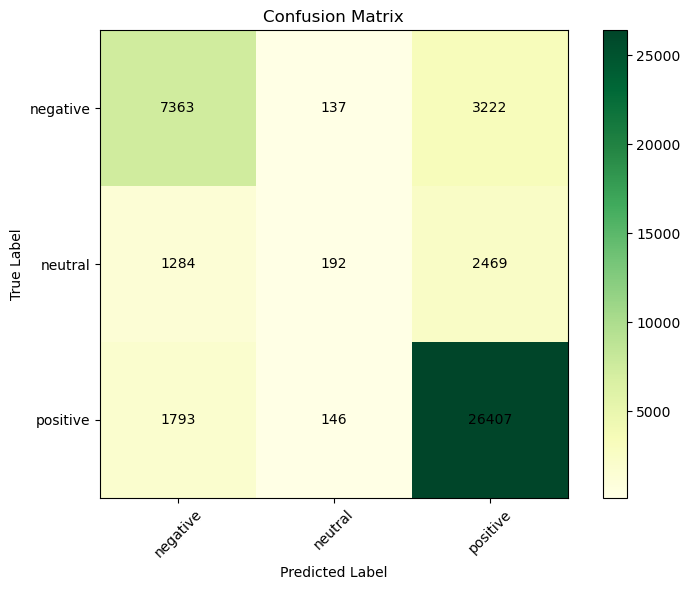

In [26]:
# Manually assign class labels
class_labels = ["negative", "neutral", "positive"]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='YlGn')
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to the axes
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)  
plt.yticks(tick_marks, class_labels)               

# Add counts to the cells
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             ha="center", va="center", color="black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [27]:
train_test_cnn = train_test_df

In [28]:
# Tokenizer and sequence preprocessing
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_test_cnn['review'])
train_sequences = tokenizer.texts_to_sequences(train_test_cnn['review'])
max_len = 100
train_data = pad_sequences(train_sequences, maxlen=max_len)

In [29]:
# Convert rating labels to indices (negative, neutral, positive)
train_labels = np.zeros((len(train_test_cnn), 3))
train_labels[:, 0] = train_test_cnn['rating'] < 5
train_labels[:, 1] = (train_test_cnn['rating'] == 5) | (train_test_cnn['rating'] == 6)
train_labels[:, 2] = train_test_cnn['rating'] > 6

train_labels = np.argmax(train_labels, axis=1) 


In [30]:
# CNN model creation
embedding_dim = 50
model = Sequential()
model.add(Embedding(10000, embedding_dim))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.02)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu', kernel_regularizer=l2(0.01)))  
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [31]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = dict(enumerate(class_weights))


In [33]:
start_time_train_cnn = time.time()
history = model.fit(train_data, train_labels, epochs=30, batch_size=128, validation_split=0.2, class_weight=class_weights_dict)
end_time_train_cnn = time.time()

Epoch 1/30
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.3533 - loss: 1.5303 - val_accuracy: 0.6578 - val_loss: 0.9516
Epoch 2/30
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6223 - loss: 0.9519 - val_accuracy: 0.5552 - val_loss: 0.9436
Epoch 3/30
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6309 - loss: 0.8970 - val_accuracy: 0.5594 - val_loss: 0.9213
Epoch 4/30
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6362 - loss: 0.8662 - val_accuracy: 0.5727 - val_loss: 0.8820
Epoch 5/30
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6387 - loss: 0.8468 - val_accuracy: 0.6054 - val_loss: 0.8611
Epoch 6/30
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6419 - loss: 0.8283 - val_accuracy: 0.6411 - val_loss: 0.7917
Epoch 7/30
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6358 - loss: 0.8247 - val_accuracy: 0.6615 - val_loss: 0.7650
Epoch 8/30
1345/1345 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6502 - loss: 

In [41]:
# Measure testing time
start_time_test_cnn = time.time()
cnn_accuracy = model.evaluate(train_data, train_labels, verbose=0) 
end_time_test_cnn = time.time()
print(f"CNN Training Time: {end_time_train_cnn - start_time_train_cnn:.2f} seconds")
print(f"CNN Testing Time: {end_time_test_cnn - start_time_test_cnn:.2f} seconds")

CNN Training Time: 378.05 seconds
CNN Testing Time: 11.66 seconds


1345/1345 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.59      0.69     10733
     Neutral       0.20      0.83      0.32      3906
    Positive       0.96      0.63      0.76     28374

    accuracy                           0.64     43013
   macro avg       0.66      0.69      0.59     43013
weighted avg       0.86      0.64      0.71     43013



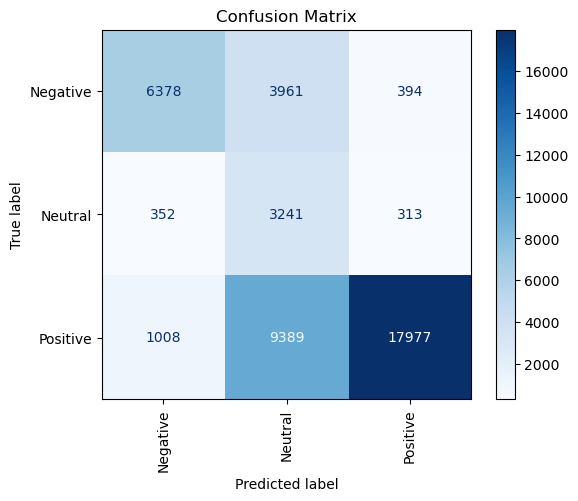

In [43]:
# Predict on validation data
X_val = train_data[int(0.8 * len(train_data)):]  # Assuming 80-20 split
y_val = train_labels[int(0.8 * len(train_labels)):]
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred, labels=[0, 1, 2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues', xticks_rotation='vertical', values_format='d') 
plt.title('Confusion Matrix')
plt.show()

In [45]:
# Filter the dataset for a specific condition
data_filtered = train_df[train_df['condition'] == "Headache"][['drugName', 'review', 'usefulCount']]


In [47]:
# Extract drug names and reviews
drug_list = data_filtered['drugName'].tolist()
review_list = data_filtered['review'].tolist()
useful_count_list = data_filtered['usefulCount'].tolist()

In [49]:
print(f"Number of reviews : {len(review_list)}")

Number of reviews : 473


In [51]:
# Function for sentiment analysis
def sentiment_analysis_with_useful_count(review):
    review_tfidf = vectorizer.transform([review])
    prediction = svc.predict(review_tfidf)[0]
    return prediction

In [53]:
# Analyze sentiment and aggregate useful counts
drug_sentiment_data = {}

for i, review in enumerate(review_list):
    sentiment = sentiment_analysis_with_useful_count(review)
    drug_name = drug_list[i]
    useful_count = useful_count_list[i]
    
    if drug_name not in drug_sentiment_data:
        drug_sentiment_data[drug_name] = {'positive_count': 0, 'useful_count_sum': 0}
    
    if sentiment == 1:  # Positive sentiment
        drug_sentiment_data[drug_name]['positive_count'] += 1
        drug_sentiment_data[drug_name]['useful_count_sum'] += useful_count
# Convert drug sentiment data to a DataFrame for sorting
drug_summary_df = pd.DataFrame.from_dict(drug_sentiment_data, orient='index')
drug_summary_df['drugName'] = drug_summary_df.index
drug_summary_df.reset_index(drop=True, inplace=True)

# Sort by positive count and useful count sum
drug_summary_df.sort_values(by=['positive_count', 'useful_count_sum'], ascending=False, inplace=True)

In [55]:
# Display the top recommended drugs for svm
top_drugs_SVM = drug_summary_df.head(5)
print("Top Recommended Drugs Based on Positive Reviews and Useful Count for svm:")
top_drugs_SVM

Top Recommended Drugs Based on Positive Reviews and Useful Count for svm:


,positive_count,useful_count_sum,drugName
0,121,2968,Acetaminophen / butalbital / caffeine
4,81,2791,Fioricet
2,45,376,Acetaminophen / dichloralphenazone / isomethep...
11,19,388,Aspirin / butalbital / caffeine / codeine
3,18,470,Naproxen


In [57]:
# Predict sentiment for the filtered data
reviews = data_filtered['review'].tolist()
drugs = data_filtered['drugName'].tolist()
useful_counts = data_filtered['usefulCount'].tolist()

# Transform reviews to TF-IDF format
reviews_tfidf = tfidf_vectorizer.transform(reviews)

# Predict sentiment
predictions = log_reg.predict(reviews_tfidf)


In [59]:

# Aggregate positive reviews and useful counts
drug_sentiment_data = {}

for i, drug in enumerate(drugs):
    sentiment = predictions[i]
    useful_count = useful_counts[i]

    if drug not in drug_sentiment_data:
        drug_sentiment_data[drug] = {'positive_count': 0, 'useful_count_sum': 0}

    if sentiment == 2:  # Positive sentiment
        drug_sentiment_data[drug]['positive_count'] += 1
        drug_sentiment_data[drug]['useful_count_sum'] += useful_count



In [61]:
# Create a DataFrame for ranking
drug_summary_lr = pd.DataFrame.from_dict(drug_sentiment_data, orient='index')
drug_summary_lr['drugName'] = drug_summary_lr.index
drug_summary_lr.reset_index(drop=True, inplace=True)

# Sort by positive count and useful count sum
drug_summary_lr.sort_values(by=['positive_count', 'useful_count_sum'], ascending=False, inplace=True)

In [63]:
# Display top recommended drugs
top_drugs_lr = drug_summary_lr.head(5)
print("Top Recommended Drugs Based on Positive Reviews and Useful Count for logistic regression:")
top_drugs_lr

Top Recommended Drugs Based on Positive Reviews and Useful Count for logistic regression:


,positive_count,useful_count_sum,drugName
0,121,2977,Acetaminophen / butalbital / caffeine
4,83,2796,Fioricet
2,42,356,Acetaminophen / dichloralphenazone / isomethep...
3,19,490,Naproxen
11,19,388,Aspirin / butalbital / caffeine / codeine


In [65]:
# Function for sentiment analysis
def sentiment_analysis_direct(review):
    sequence = pad_sequences(tokenizer.texts_to_sequences([review]), maxlen=100)
    prediction = model.predict(sequence)[0]
    sentiment = np.argmax(prediction)
    if sentiment == 0:
        return "Negative"
    elif sentiment == 1:
        return "Neutral"
    elif sentiment == 2:
        return "Positive"


In [67]:
# Extract drug names, reviews, and useful counts
drug_list = data_filtered['drugName'].tolist()
review_list = data_filtered['review'].tolist()
useful_count_list = data_filtered['usefulCount'].tolist()


In [69]:
# Analyze sentiment and aggregate useful counts
drug_sentiment_data = {}

for i, review in enumerate(review_list):
    sentiment = sentiment_analysis_direct(review)
    drug_name = drug_list[i]
    useful_count = useful_count_list[i]
    
    if drug_name not in drug_sentiment_data:
        drug_sentiment_data[drug_name] = {'positive_count': 0, 'useful_count_sum': 0}
    
    if sentiment == "Positive":
        drug_sentiment_data[drug_name]['positive_count'] += 1
        drug_sentiment_data[drug_name]['useful_count_sum'] += useful_count

# Convert drug sentiment data to a DataFrame for sorting
drug_summary_cnn = pd.DataFrame.from_dict(drug_sentiment_data, orient='index')
drug_summary_cnn['drugName'] = drug_summary_cnn.index
drug_summary_cnn.reset_index(drop=True, inplace=True)

# Sort drugs by positive count and useful count sum
drug_summary_cnn.sort_values(by=['positive_count', 'useful_count_sum'], ascending=False, inplace=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [71]:
# Display the top recommended drugs for svm
top_drugs_SVM = drug_summary_df.head(5)
print("Top Recommended Drugs Based on Positive Reviews and Useful Count for svm:")
top_drugs_SVM

Top Recommended Drugs Based on Positive Reviews and Useful Count for svm:


,positive_count,useful_count_sum,drugName
0,121,2968,Acetaminophen / butalbital / caffeine
4,81,2791,Fioricet
2,45,376,Acetaminophen / dichloralphenazone / isomethep...
11,19,388,Aspirin / butalbital / caffeine / codeine
3,18,470,Naproxen


In [73]:
# Display top recommended drugs for logistic regression
top_drugs_lr = drug_summary_lr.head(5)
print("Top Recommended Drugs Based on Positive Reviews and Useful Count for logistic regression:")
top_drugs_lr

Top Recommended Drugs Based on Positive Reviews and Useful Count for logistic regression:


,positive_count,useful_count_sum,drugName
0,121,2977,Acetaminophen / butalbital / caffeine
4,83,2796,Fioricet
2,42,356,Acetaminophen / dichloralphenazone / isomethep...
3,19,490,Naproxen
11,19,388,Aspirin / butalbital / caffeine / codeine


In [75]:
# Display the top recommended drugs for cnn
top_drugs_cnn = drug_summary_cnn.head(5)
print("Top Recommended Drugs Based on Positive Reviews and Useful Count for cnn:")
top_drugs_cnn

Top Recommended Drugs Based on Positive Reviews and Useful Count for cnn:


,positive_count,useful_count_sum,drugName
0,69,1806,Acetaminophen / butalbital / caffeine
4,49,1687,Fioricet
2,24,199,Acetaminophen / dichloralphenazone / isomethep...
11,15,299,Aspirin / butalbital / caffeine / codeine
7,11,80,Ibuprofen
